# SVM Classifier (BERT-Boosted) x Toxic Content Detection
Il presente Notebook mostra l'addestramento ed il testing di un Classificatore basato su SVM per il task di Toxic Content Detection.

I dati sono stati processati come segue:
1. Pulizia del testo (si veda 'dataset_preprocessing.py')
2. Estrazione delle Features mediante BERT (si veda 'feature_extraction_bert_windows.ipynb'/'feature_extraction_bert_mac.ipynb')


In [1]:
import pandas as pd
import numpy as np
import pickle
import nltk
import re
import torch
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from datetime import datetime
from sklearn.metrics import accuracy_score,precision_score,recall_score, confusion_matrix, ConfusionMatrixDisplay

e:\anaconda3\envs\DLProjectCUDA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Caricamento del Training Set

In [2]:
training_set = pd.read_csv("./../../datasets/training_set.csv")

# Osservazione: il Training Set è stato già ripulito
training_set

,comment_text,toxic
0,cocksucker before you piss around on my work,1
1,hey what is it talk what is it an exclusive gr...,1
2,bye dont look come or think of comming back to...,1
3,you are gay or antisemmitian archangel white t...,1
4,fuck your filthy mother in the ass dry,1
...,...,...
30572,chris i dont know who you are talking to but i...,0
30573,operation condor is also named a dirty war can...,0
30574,there is no evidence that this block has anyth...,0
30575,thanks hey utkarshraj thanks for the kindness ...,0


In [3]:
y_train = training_set['toxic']

# Addestramento del Sistema
Il Sistema è ovviamente riaddestrabile a piacere. Si consiglia, tuttavia, dato il tempo necessario per riaddestrare il classificatore, di utilizzare il file pickle 'svm_classifier' per eseguire subito gli esperimenti.

In [4]:
X_train = pd.read_csv("./../../datasets/X_train_bert.csv")
print("X_train.shape", X_train.shape)

X_train.shape (30577, 768)


In [5]:
kernel = 'poly'

model_filename = '{}_svm_classifier.pkl'.format(kernel)
cl = None

Esegui la seguente sottosezione per riaddestrare il Classificatore da capo. Il modello ottenuto verrà persistito nel file '{kernel}_svm_classifier.pkl'.

In [6]:
cl = SVC(kernel=kernel, probability=True, random_state = 24)

In [7]:
print("Training started...")
start = datetime.now()
cl.fit(X=X_train, y=y_train)
end = datetime.now()
print("Training completed! Required time: " + str(end-start))

with open(model_filename, 'wb') as f:
    pickle.dump(cl, f)

Training started...


Training completed! Required time: 0:10:32.670575


Esegui la seguente sottosezione per utilizzare il Classificatore già addestrato.

In [8]:
with open(model_filename, 'rb') as f:
    cl = pickle.load(f)

# Testing del Sistema

In [9]:
test_data = pd.read_csv("./../../datasets/test_set.csv")
test_data.dropna(inplace=True)
test_set = test_data[test_data['toxic'] != -1]

In [10]:
y_test = test_set['toxic']
print("y_test.shape: " + str(y_test.shape))

y_test.shape: (63842,)


In [11]:
X_test = pd.read_csv("./../../datasets/X_test_bert.csv")
print("X_test.shape:", X_test.shape)

X_test.shape: (63842, 768)


Predizioni

In [12]:
y_pred = cl.predict(X_test)

#Metriche: Accuracy,Precision,Recall
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))

Accuracy: 0.8432849848062404
Precision: 0.36820505920344454
Recall: 0.899129291933629


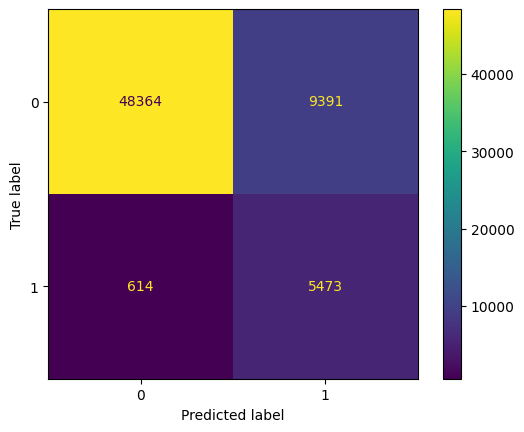

In [13]:
cm = confusion_matrix(y_test, y_pred, labels=cl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cl.classes_)
disp.plot()
plt.show()

## Funzioni di Supporto
Da utilizzare qualora si volesse effettuare una predizione su una frase "inedita".

In [14]:
# Pulizia della Frase
def clean_phrases(phrases):
    new_phrases = list()
    for phrase in phrases:
        # Rimozione di "\r" e "\n"
        phrase = re.sub(r'[\r\n]+', '', phrase)
        # Rimozione di sequenze di ":" (esempio, "::::")
        phrase = re.sub(r'::+', '', phrase)
        # Rimozione di sequenze di "=" (esempio, "====")
        phrase = re.sub(r'==+', '', phrase)
        # Rimozione di sequenze di "*" (esempio, "**")
        phrase = re.sub(r'\*\*+', '', phrase)
        # Rimozione di sequenze numeriche in formato di indirizzi IP (esempio, "192.168.1.1")
        phrase = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '', phrase)
        # Rimozione di contenuto compreso tra Parentesi Quadre (esempio, "[contentContent]")
        phrase = re.sub(r'\[[^\[\]]+\]', '', phrase)
        # Rimozione di Apici, sia singoli che doppi
        phrase = re.sub(r"['\"]", "", phrase)

        ## La rimozione di particolari caratteri o sequenze di caratteri può portare alla fusione di due token diversi

        # Splitting di token in cui compare un segno di interpuzione forte ("?", "!" e ".") seguito da una lettera maiuscola
        phrase = re.sub(r'([?!\.])([A-Z]\w*)', r'\1 \2', phrase)
        # Splitting di parole fuse (esempio, "parolaParola" diventa "parola Parola")
        phrase = re.sub(r'([a-z])([A-Z])', r'\1 \2', phrase)

        tokens = word_tokenize(phrase)
        lowercase_tokens = [token.lower() for token in tokens if token.isalpha()]
        new_phrases.append(' '.join(lowercase_tokens))
    
    return new_phrases

In [15]:
# Carica il tokenizer e il modello preaddestrato di BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [16]:
# Definizione di una funzione per estrarre le caratteristiche di un testo utilizzando BERT
def extract_features(strings):
    # return_tensors ritorna il tensore per la versione pytorch
    # padding = true fa in modo che frasi di lunghezza diversa vengono portate alla lunghezza massima
    inputs = tokenizer(strings, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    #rappresentazione media e unidimensionale delle caratteristiche estratte
    features = torch.mean(last_hidden_states, dim=1).squeeze()
    features = features.numpy()
    return pd.DataFrame(features)

Esempio:

In [17]:
text = "Today I went to the office at 9 o'clock and there were a lot of people."

In [18]:
# nltk.download('wordnet')
# nltk.download('punkt')

In [19]:
phrases = clean_phrases([text])

string = phrases[0]

In [20]:
string_to_vec = extract_features(string)
string_to_vec = string_to_vec.T # Estract Features

In [21]:
#predict_proba calcola la probabilità di ogni etichetta
print(str(cl.predict(string_to_vec)) + " -> " + str(cl.predict_proba(string_to_vec)))

[0] -> [[0.93558204 0.06441796]]


e:\anaconda3\envs\DLProjectCUDA\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
e:\anaconda3\envs\DLProjectCUDA\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [23]:
text2 = "I hate you all and i hope you die."
phrases = clean_phrases([text2])
string = phrases[0]
string_to_vec = extract_features(string)
string_to_vec = string_to_vec.T
print(str(cl.predict(string_to_vec)) + " -> " + str(cl.predict_proba(string_to_vec)))

[1] -> [[5.99851036e-08 9.99999940e-01]]


e:\anaconda3\envs\DLProjectCUDA\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
e:\anaconda3\envs\DLProjectCUDA\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
